# Brief about problem

Objective is to training generative models to create images of dogs. Model will be evaluated the basis of how well images are classified as dogs.

In [1]:
import keras

In [2]:
keras.optimizers

<module 'keras.optimizers' from '/Users/vishalverma/tensorflow/env/lib/python3.8/site-packages/keras/optimizers.py'>

In [3]:
import numpy as np
import pandas as pd 
import keras
from keras.layers import Input, Dense, Reshape, Flatten, Dropout,Concatenate
from keras.backend import random_normal,ones_like,zeros_like,mean
from keras.backend import get_session
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.layers import concatenate
from keras.initializers import TruncatedNormal
from keras.callbacks import LearningRateScheduler, EarlyStopping, History
from PIL import Image
import warnings
import os
import time
from glob import glob
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np, pandas as pd, os
import xml.etree.ElementTree as ET 
import matplotlib.pyplot as plt, zipfile 
from PIL import Image 
from glob import glob

In [4]:
directory1 = r'/Users/vishalverma/Vishal/Github_project/Data'

In [5]:
print(os.listdir(directory1))

['.DS_Store', 'Annotation', 'all-dogs']


In [6]:
len(os.listdir(directory1 + '/all-dogs'))

20579

We have 20579 images in training data set.

# Exploring random images

/var/folders/xf/6fdb6j7912v8q7z1m24hkzlw0000gn/T/ipykernel_4772/2116966117.py:65: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((w2,h2), Image.ANTIALIAS)


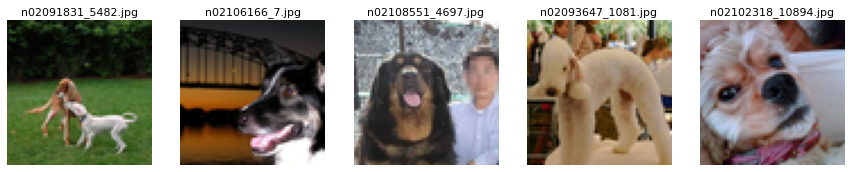

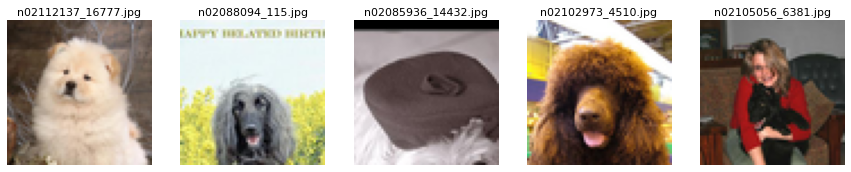

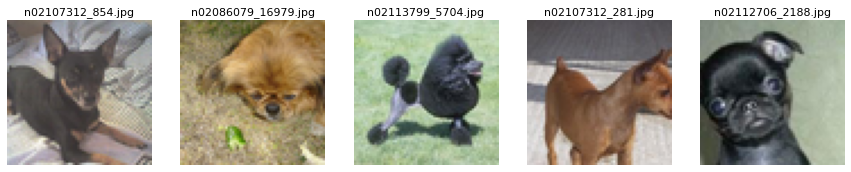

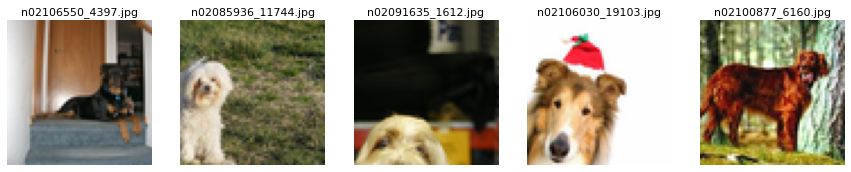

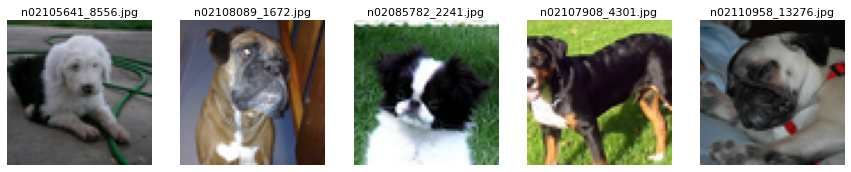

In [7]:
ComputeLB = False
DogsOnly = False

import numpy as np, pandas as pd, os
import xml.etree.ElementTree as ET 
import matplotlib.pyplot as plt, zipfile 
from PIL import Image 

ROOT = directory1
if not ComputeLB: ROOT = directory1
IMAGES = os.listdir(ROOT + '/all-dogs/')
breeds = os.listdir(ROOT + '/Annotation/') 

idxIn = 0; namesIn = []
imagesIn = np.zeros((25000,64,64,3))

# CROP WITH BOUNDING BOXES TO GET DOGS ONLY
# https://www.kaggle.com/paulorzp/show-annotations-and-breeds
if DogsOnly:
    for breed in breeds:
        for dog in os.listdir(ROOT+'annotation/Annotation/'+breed):
            try: img = Image.open(ROOT+'all-dogs/all-dogs/'+dog+'.jpg') 
            except: continue           
            tree = ET.parse(ROOT+'annotation/Annotation/'+breed+'/'+dog)
            root = tree.getroot()
            objects = root.findall('object')
            for o in objects:
                bndbox = o.find('bndbox') 
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                w = np.min((xmax - xmin, ymax - ymin))
                img2 = img.crop((xmin, ymin, xmin+w, ymin+w))
                img2 = img2.resize((64,64), Image.ANTIALIAS)
                imagesIn[idxIn,:,:,:] = np.asarray(img2)
                #if idxIn%1000==0: print(idxIn)
                namesIn.append(breed)
                idxIn += 1
    idx = np.arange(idxIn)
    np.random.shuffle(idx)
    imagesIn = imagesIn[idx,:,:,:]
    namesIn = np.array(namesIn)[idx]
    
# RANDOMLY CROP FULL IMAGES
else:
    IMAGES = np.sort(IMAGES)
    np.random.seed(810)
    x = np.random.choice(np.arange(20579),10000)
    np.random.seed(None)
    for k in range(len(x)):
        img = Image.open(ROOT + '/all-dogs/' + IMAGES[x[k]])
        w = img.size[0]; h = img.size[1];
        if (k%2==0)|(k%3==0):
            w2 = 100; h2 = int(h/(w/100))
            a = 18; b = 0          
        else:
            a=0; b=0
            if w<h:
                w2 = 64; h2 = int((64/w)*h)
                b = (h2-64)//2
            else:
                h2 = 64; w2 = int((64/h)*w)
                a = (w2-64)//2
        img = img.resize((w2,h2), Image.ANTIALIAS)
        img = img.crop((0+a, 0+b, 64+a, 64+b))    
        imagesIn[idxIn,:,:,:] = np.asarray(img)
        namesIn.append(IMAGES[x[k]])
        idxIn += 1
    
# DISPLAY CROPPED IMAGES
x = np.random.randint(0,idxIn,25)
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray( imagesIn[x[k*5+j],:,:,:].astype('uint8') )
        plt.axis('off')
        if not DogsOnly: plt.title(namesIn[x[k*5+j]],fontsize=11)
        else: plt.title(namesIn[x[k*5+j]].split('-')[1],fontsize=11)
        plt.imshow(img)
    plt.show()

In [8]:
IMG_SIZE = Input((12288,))
IMG_SIZE_2 = Input((10000,))
NOISE_SIZE = 10000
BATCH_SIZE = 100

# Building Discriminator

In [9]:
def discriminatorFunction():
    
    input_layer = Dense(12288, activation='sigmoid')(IMG_SIZE_2) 
    input_layer = Reshape((2,12288,1))(concatenate([IMG_SIZE,input_layer]))
    discriminator = Conv2D(filters = 1, kernel_size=[2,1],use_bias=False, name = 'layer_1')(input_layer)
    out = Flatten()(discriminator)
    return out

In [10]:
print("Discriminator")
model = discriminatorFunction()
model_discriminator = Model([IMG_SIZE,IMG_SIZE_2], model)
model_discriminator.get_layer('layer_1').trainable = False
model_discriminator.get_layer('layer_1').set_weights([np.array([[[[-1.0 ]]],[[[1.0]]]])])
model_discriminator.summary()
model_discriminator.compile(optimizer='adam', loss='binary_crossentropy')

Discriminator
Metal device set to: Apple M1


2022-06-26 15:53:50.197242: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-26 15:53:50.197455: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10000)]      0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 12288)]      0           []                               
                                                                                                  
 dense (Dense)                  (None, 12288)        122892288   ['input_2[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 24576)        0           ['input_1[0][0]',                
                                                                  'dense[0][0]']              

# Build Generator

In [11]:
def GeneratorFunction(noise_shape=(NOISE_SIZE,)):
    input_layer = Input(noise_shape)
    generated = Dense(12288, activation='linear')(input_layer)
        
# COMPILE
    model = Model(inputs=input_layer,outputs = [generated,Reshape((10000,))(input_layer)])
    model.summary()
  
    return model

In [12]:
print("Generator")
model_generator = GeneratorFunction(noise_shape=(NOISE_SIZE,))

Generator
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 10000)]      0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 12288)        122892288   ['input_3[0][0]']                
                                                                                                  
 reshape_1 (Reshape)            (None, 10000)        0           ['input_3[0][0]']                
                                                                                                  
Total params: 122,892,288
Trainable params: 122,892,288
Non-trainable params: 0
__________________________________________________________________________________________________


# Training discriminator

In [13]:
# TRAINING DATA
train_y = (imagesIn[:10000,:,:,:]/255.).reshape((-1,12288))
train_X = np.zeros((10000,10000))
for i in range(10000): train_X[i,i] = 1
zeros = np.zeros((10000,12288))

# ---------------------
#  Train Discriminator
# ---------------------

from keras.callbacks import EarlyStopping, ModelCheckpoint

#early_stopping = EarlyStopping(monitor = 'loss', patience = 5)
#checkpointer = ModelCheckpoint(filepath='weights.hdf5', 
 #                              verbose=1, save_best_only=True)

# orig
lr = 0.5
# Let's play with lr
#lr = 0.3 # gives ~7.251
for k in range(4):
    LR_Scheduler = LearningRateScheduler(lambda x: lr)
    h = model_discriminator.fit([zeros,train_X], train_y, epochs = 10,batch_size = BATCH_SIZE, 
                                callbacks=[LR_Scheduler], verbose=1)
    print('Epoch',(k+1)*10,'/50 - loss =',h.history['loss'][-1] )
    if h.history['loss'][-1]<0.533: lr = lr*0.1

Epoch 1/10


2022-06-26 15:53:53.234911: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-26 15:53:53.619915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 19s 177ms/step - loss: 0.6855 - lr: 0.5000
Epoch 2/10
100/100 [==============================] - 17s 174ms/step - loss: 0.6338 - lr: 0.5000
Epoch 3/10
100/100 [==============================] - 17s 173ms/step - loss: 0.5863 - lr: 0.5000
Epoch 4/10
100/100 [==============================] - 17s 172ms/step - loss: 0.5597 - lr: 0.5000
Epoch 5/10
100/100 [==============================] - 17s 173ms/step - loss: 0.5469 - lr: 0.5000
Epoch 6/10
100/100 [==============================] - 18s 178ms/step - loss: 0.5408 - lr: 0.5000
Epoch 7/10
100/100 [==============================] - 17s 174ms/step - loss: 0.5377 - lr: 0.5000
Epoch 8/10
100/100 [==============================] - 17s 175ms/step - loss: 0.5360 - lr: 0.5000
Epoch 9/10
100/100 [==============================] - 17s 175ms/step - loss: 0.5350 - lr: 0.5000
Epoch 10/10
100/100 [==============================] - 18s 176ms/step - loss: 0.5343 - lr: 0.5000
Epoch 10 /50 - loss = 0.5343264937400818

In [14]:
del train_X, train_y, imagesIn

Discriminator Recalls from Memory Dogs


2022-06-26 16:05:47.548712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


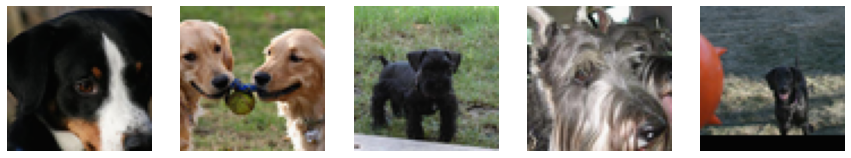

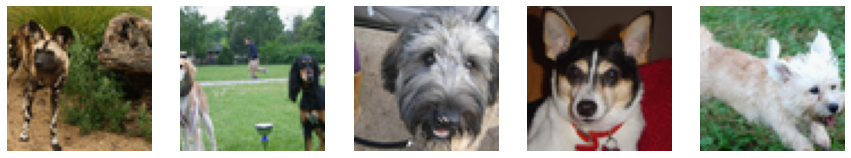

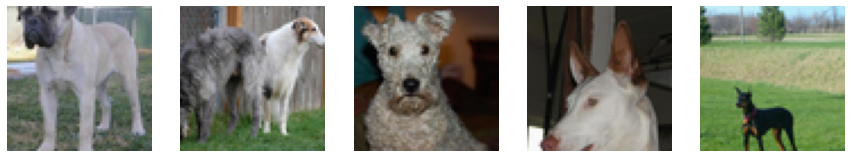

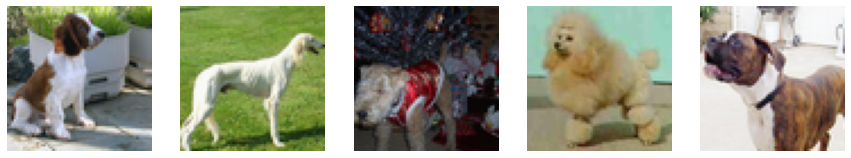

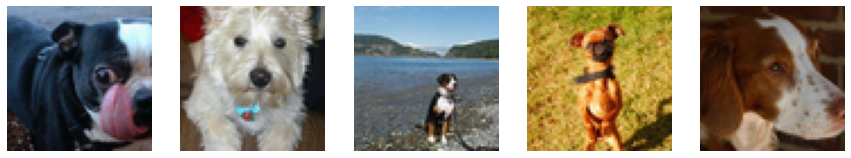

In [15]:
print('Discriminator Recalls from Memory Dogs')    
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        xx = np.zeros((10000))
        xx[np.random.randint(10000)] = 1
        plt.subplot(1,5,j+1)
        img = model_discriminator.predict([zeros[0,:].reshape((-1,12288)),xx.reshape((-1,10000))]).reshape((-1,64,64,3))
        img = Image.fromarray( (255*img).astype('uint8').reshape((64,64,3)))
        plt.axis('off')
        plt.imshow(img)
    plt.show()

# Building GAN model

In [16]:
# BUILD GENERATIVE ADVERSARIAL NETWORK
model_discriminator.trainable = False #discriminator is not trainable for GANs
z = Input(shape=(NOISE_SIZE,))
img = model_generator(z)
real = model_discriminator(img)

# COMPILE GAN
gan = Model(z, real)

In [25]:
# BUILD GENERATIVE ADVERSARIAL NETWORK
model_discriminator.trainable = False #discriminator is not trainable for GANs
z = Input(shape=(NOISE_SIZE,))
img = model_generator(z)
real = model_discriminator(img)

# COMPILE GAN
gan = Model(z, real)
gan.get_layer('model').get_layer('layer_1').set_weights([np.array([[[[-1 ]]],[[[255.]]]])])
gan.compile(optimizer=Adam(5), loss='mean_squared_error')

# DISPLAY ARCHITECTURE
print("Model created based on Discriminator and Generator")
gan.summary()

Model created based on Discriminator and Generator
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 10000)]      0           []                               
                                                                                                  
 model_1 (Functional)           [(None, 12288),      122892288   ['input_5[0][0]']                
                                 (None, 10000)]                                                   
                                                                                                  
 model (Functional)             (None, 12288)        122892290   ['model_1[1][0]',                
                                                                  'model_1[1][1]']                
                                         

In [26]:
train = np.zeros((10000,10000))
for i in range(10000): train[i,i] = 1
zeros = np.zeros((10000,12288))

Steps_per_epoch = 50

print("Training begins... Total steps per epoch: {}".format(Steps_per_epoch ))

Training begins... Total steps per epoch: 50


2022-06-26 16:14:32.545061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 11s 258ms/step - loss: 6887.2085 - lr: 5.0000
Step: 10/500 [G loss: 6887.2085]


2022-06-26 16:14:43.565378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


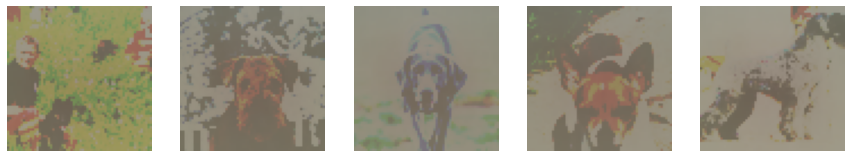

40/40 [==============================] - 11s 253ms/step - loss: 2681.8110 - lr: 5.0000
Step: 20/500 [G loss: 2681.8110]


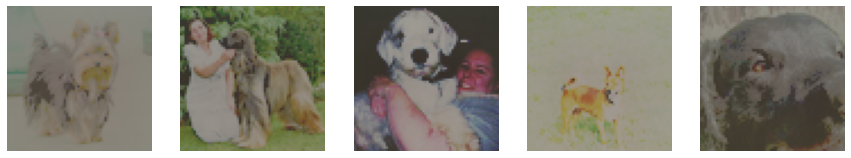

40/40 [==============================] - 11s 253ms/step - loss: 1156.1509 - lr: 5.0000
Step: 30/500 [G loss: 1156.1509]


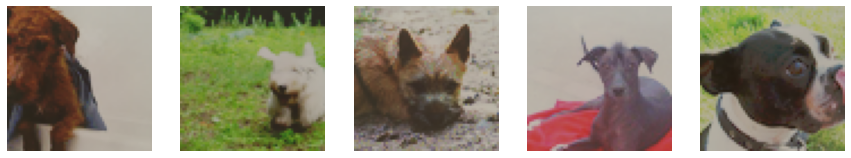

40/40 [==============================] - 11s 252ms/step - loss: 485.7666 - lr: 5.0000
Step: 40/500 [G loss: 485.7666]


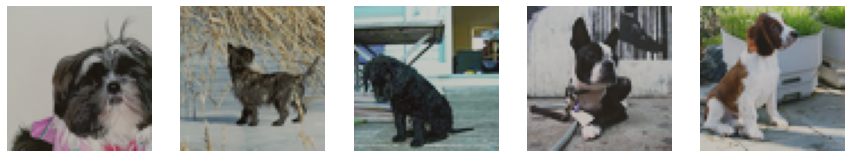

40/40 [==============================] - 11s 253ms/step - loss: 201.1521 - lr: 5.0000
Step: 50/500 [G loss: 201.1521]


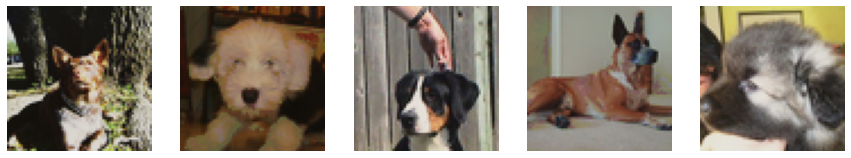

40/40 [==============================] - 10s 254ms/step - loss: 87.5493 - lr: 5.0000
Step: 60/500 [G loss: 87.5493]


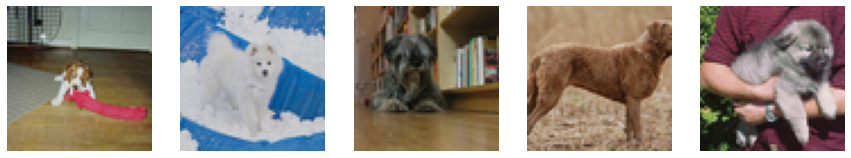

40/40 [==============================] - 11s 252ms/step - loss: 43.4980 - lr: 5.0000
Step: 70/500 [G loss: 43.4980]


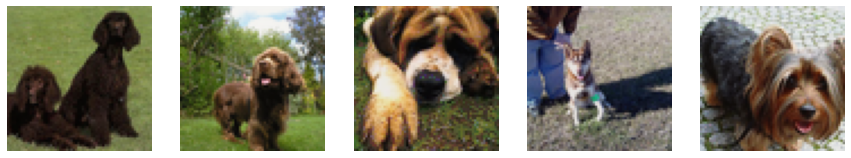

40/40 [==============================] - 10s 254ms/step - loss: 28.1237 - lr: 5.0000
Step: 80/500 [G loss: 28.1237]


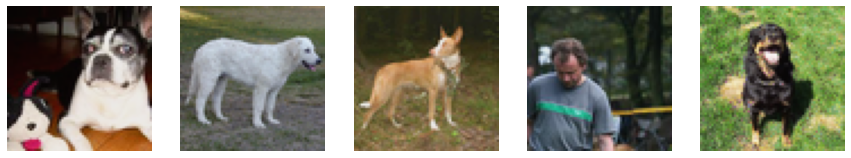

40/40 [==============================] - 11s 253ms/step - loss: 23.4331 - lr: 5.0000
Step: 90/500 [G loss: 23.4331]


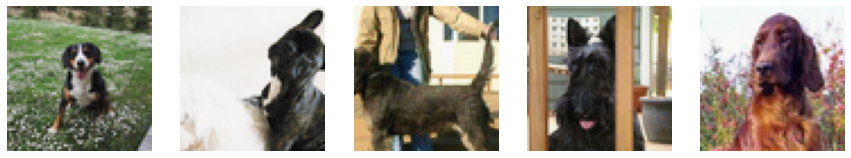

40/40 [==============================] - 11s 252ms/step - loss: 15.8698 - lr: 1.0000
Step: 100/500 [G loss: 15.8698]


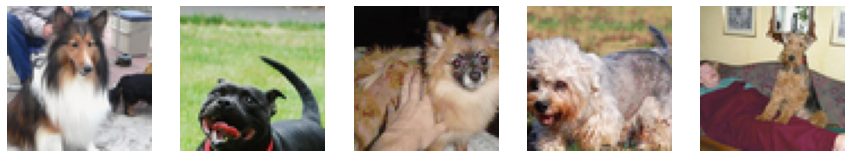

40/40 [==============================] - 10s 252ms/step - loss: 2.0800 - lr: 1.0000
Step: 150/500 [G loss: 2.0800]
40/40 [==============================] - 10s 255ms/step - loss: 1.3666 - lr: 0.0000e+00
Step: 200/500 [G loss: 1.3666]
40/40 [==============================] - 11s 264ms/step - loss: 1.3666 - lr: 0.0000e+00
Step: 250/500 [G loss: 1.3666]
40/40 [==============================] - 10s 257ms/step - loss: 1.3666 - lr: 0.0000e+00
Step: 300/500 [G loss: 1.3666]
40/40 [==============================] - 10s 257ms/step - loss: 1.3666 - lr: 0.0000e+00
Step: 350/500 [G loss: 1.3666]
40/40 [==============================] - 11s 271ms/step - loss: 1.3666 - lr: 0.0000e+00
Step: 400/500 [G loss: 1.3666]
40/40 [==============================] - 12s 295ms/step - loss: 1.3666 - lr: 0.0000e+00
Step: 450/500 [G loss: 1.3666]
40/40 [==============================] - 12s 296ms/step - loss: 1.3666 - lr: 0.0000e+00
Step: 500/500 [G loss: 1.3666]


In [27]:
warnings.filterwarnings("ignore")

lr = 5.

for step in range(Steps_per_epoch):
        
    # ---------------------
    #  Train GAN
    # ---------------------
    LR_Scheduler = LearningRateScheduler(lambda x: lr)
    h = gan.fit(train, zeros, epochs = 1, batch_size=256, callbacks=[LR_Scheduler], verbose=1)

    # DISPLAY GENERATOR LEARNING PROGRESS 
    if (step<10)|(step%5==4):
        
        print ("Step: {}/{} [G loss: {:.4f}]".format(
                     (step+1)*10, Steps_per_epoch*10, h.history['loss'][-1]))
        
    if h.history['loss'][-1] < 25: lr = 1.
    #if h.history['loss'][-1] < 1.5: lr = 0.5 # orig
    #if h.history['loss'][-1] < 1.5: lr = 0.05 # test gaves ~7.23
    if h.history['loss'][-1] < 1.5: lr = 0.01 # test gaves ~7.23 
        
    # DISPLAY GENERATOR LEARNING PROGRESS
    
    if step<10: 
    
        # Plot images
        plt.figure(figsize=(15,3))
        for j in range(5):
            zz = np.zeros((10000))
            zz[np.random.randint(10000)] = 1
            plt.subplot(1,5,j+1)
            img = model_generator.predict(zz.reshape((-1,10000)))[0].reshape((-1,64,64,3))
            img = Image.fromarray( (img).astype('uint8').reshape((64,64,3)))
            plt.axis('off')
            plt.imshow(img)
        plt.show() 

In [28]:
class DogGenerator:
    index = 0   
    def getDog(self,seed):
        xx = np.zeros((10000))
        xx[self.index] = 0.999
        xx[np.random.randint(10000)] = 0.001
        img = model_generator.predict(xx.reshape((-1,10000)))[0].reshape((64,64,3))
        self.index = (self.index+1)%10000
        return Image.fromarray( img.astype('uint8') ) 

In [29]:
# SAVE TO ZIP FILE NAMED IMAGES.ZIP
z = zipfile.PyZipFile('images.zip', mode='w')
d = DogGenerator()
for k in range(10000):
    img = d.getDog(np.random.normal(0,1,100))
    f = str(k)+'.png'
    img.save(f,'PNG'); z.write(f); os.remove(f)
    #if k % 1000==0: print(k)
z.close()